# **Trotterized Anderson Model Simulation and Error Analysis**

This notebook simulates Anderson Localization using Trotterized quantum circuits and analyzes the error introduced by Trotterization. It includes code for constructing the Hamiltonian, running quantum simulations with Qiskit gates, visualizing the evolution of excitation position and variance, and plotting the Trotter error as a function of the number of steps. The notebook also demonstrates how gate grouping can minimize Trotter error.

In Anderson.ipynb, we calculated a time-evolution operator then used Qiskit's built-in unitary function to transform it into a series of gates that the quantum computer simulator could understand. Unfortunately, this process of breaking down the matrix is complex and inefficient, causing the code to take a long time to run. In this notebook, we break down the time evolution operator into individual gates using a Trotter decomposition then manually place these gates into the quantum circuit. This way, we save time by creating simpler circuits for the simulator to run. There is more info about the specific breakdown below but the general idea is that we break the time evolution operator down into individual $e^{-itXX}$, $e^{-itYY}$, and $e^{-itZ}$ gates which we model using $R_{xx}$, $R_{yy}$, and $R_{z}$ gates respectively. 

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy
import functools as ft
import random
from scipy.signal import savgol_filter as savitzky_golay
from qiskit.quantum_info import Operator

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

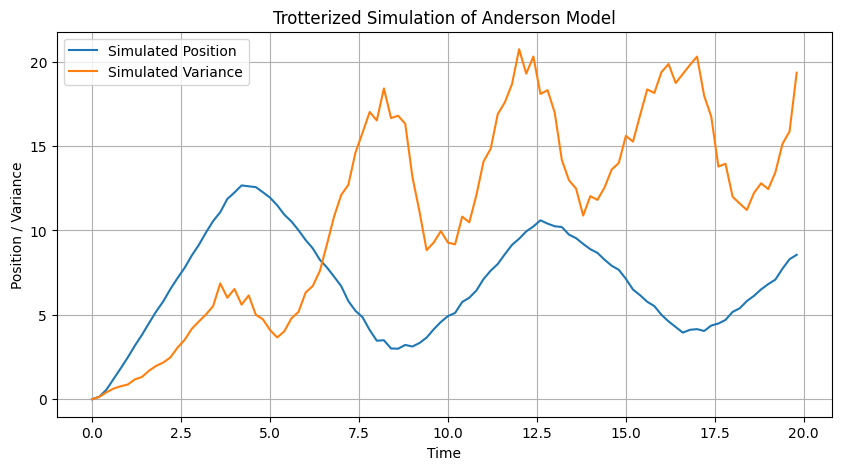

In [21]:
simulator = Aer.get_backend('aer_simulator')
frequencies = []

def run_trotterized_simulation_qiskit_gates(steps, time_range, random_factor, num_qubits):
    # Generates a random "landscape"
    b = [random.random()*random_factor for _ in range(num_qubits)]
    # b = [0, 0, 5000, 0, 0, 0, 5000, 0, 0, 0]  # Fixed values for testing
    shots = 1000
    positions = []
    variances = []

    for t in time_range:
        circuit = QuantumCircuit(num_qubits)
        circuit.x(0)

        # One step of the Trotterization
        for i in range(steps):

            dt = t/steps
            # Adding gates in alternating fashion (maximizes parallelization)
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            for j in range(num_qubits):
                circuit.rz(phi=b[j]*dt, qubit=j)
            

        circuit.measure_all()

        compiled_circuit = transpile(circuit, simulator)
        job = simulator.run(compiled_circuit, shots=shots)
        result = job.result()
        counts = dict(result.get_counts())
        filtered_counts = {s: freq for s, freq in counts.items() if s.count('1') == 1} # Only keep states with one excitation

        avg_location = 0
        for bitstring, freq in sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True):
            location = num_qubits-1-bitstring.index('1')
            avg_location += location * freq / sum(filtered_counts.values())
            # print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
        # print(avg_location)

        variance = 0
        for bitstring, freq in sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True):
            location = num_qubits-1-bitstring.index('1')
            variance += (location - avg_location) ** 2 * freq / sum(filtered_counts.values())
            frequencies.append([t, location, freq / sum(filtered_counts.values())])

        positions.append(avg_location)
        variances.append(variance)
    
    return positions, variances

trotter_steps = 200
total_time = 20
time_step_size = 0.2
random_factor = 0
num_qubits = 15

time_range = np.arange(0, total_time, time_step_size)

simulated_positions, simulated_variances = run_trotterized_simulation_qiskit_gates(trotter_steps, time_range, random_factor, num_qubits)
plt.figure(figsize=(10, 5))
plt.plot(time_range, simulated_positions, label='Simulated Position')
plt.plot(time_range, simulated_variances, label='Simulated Variance')
plt.xlabel('Time')
plt.ylabel('Position / Variance')
plt.title('Trotterized Simulation of Anderson Model')
plt.legend()
plt.grid()
plt.show()

*Notes*

We get the same result with a trotterized circuit as compared to the code from Anderson.ipynb. However, this simulation ran significantly faster since it doesn't need break down the unitary matrix into elementary quantum gates. The old code failed to run simulations with more than 10 qubits in less than a minute while the trotterized circuit can simulate up to 15 qubits in less than 50 seconds (this statistic is particularly amazing if you consider that time taken scales exponentially with increasing qubits)!

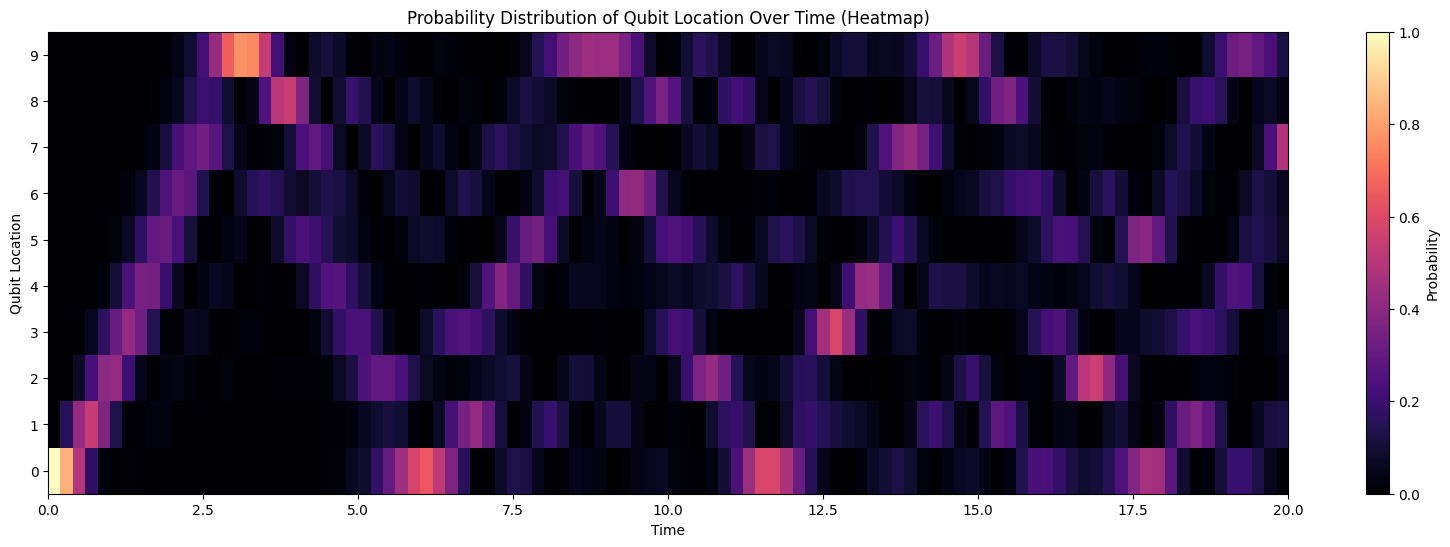

In [7]:
# Convert frequencies to numpy array for easier manipulation
freq_arr = np.array(frequencies)
locations = np.arange(0, num_qubits, 1)
probs = freq_arr[:, 2]

# Create a 2D grid for the heatmap

heatmap = np.zeros((len(locations), len(time_range)))

for t, loc, p in freq_arr:
    time_idx = np.where(time_range == t)[0][0]
    loc_idx = np.where(locations == loc)[0][0]
    heatmap[loc_idx, time_idx] = p

plt.figure(figsize=(20, 6))
im = plt.imshow(
    heatmap,
    aspect='auto',
    origin='lower',
    cmap='magma',
    extent=[0, total_time, 0, num_qubits]
)
plt.colorbar(im, label='Probability')
plt.xlabel('Time')
plt.ylabel('Qubit Location')
plt.title('Probability Distribution of Qubit Location Over Time (Heatmap)')
plt.ylim(0, num_qubits)
# show every tick on y axis
plt.yticks(np.arange(0.5, num_qubits+0.5, 1), np.arange(0, num_qubits, 1)) # center tick marks

plt.grid(False)
plt.show()

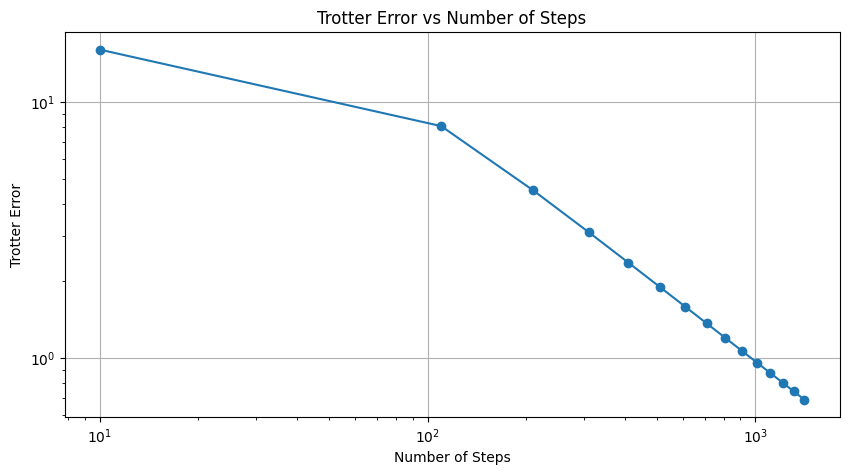

In [22]:
def get_gi(gate, i, n, get_gi1=False):
    gates = []
    for j in range(n):
        if j == i or (j == i+1 and get_gi1):
            gates.append(gate)
        else:
            gates.append(I)
    return ft.reduce(np.kron, gates)

# Creates a Hamiltonian for the Anderson model
def construct_hamiltonian(n):
    b = [1 for i in range(n)]
    b2 = [1 for i in range(n-1)]

    h1 = sum(b2[i]*(get_gi(X, i, n, True) + get_gi(Y, i, n, True)) for i in range(n-1))
    h2 = sum((b[i] * get_gi(Z, i, n)) for i in range(n))
    return h1 + h2

def u(t, H):
    return scipy.linalg.expm(-1j * H * t)

def calculate_trotter_error(num_qubits, max_steps):
    r = range(10, max_steps, 100)

    error_values = []

    ideal = u(10, construct_hamiltonian(num_qubits))

    for steps in r:

        circuit = QuantumCircuit(num_qubits)
        dt = 10/steps
        for _ in range(steps):
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            for j in range(num_qubits):
                circuit.rz(phi=2*dt, qubit=j)
    
        trotterized_matrix = Operator(circuit)
        error = scipy.linalg.norm(ideal - trotterized_matrix)
        error_values.append(error)

    return error_values

Max_Steps = 1500
errors = calculate_trotter_error(7, Max_Steps)

plt.figure(figsize=(10, 5))
plt.plot(range(10, Max_Steps, 100), errors, marker='o')
plt.title('Trotter Error vs Number of Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Trotter Error')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

**Some Notes**

Trotterization done by splitting hamiltonian into groups of $R_{xx}$, $R_{yy}$, and $R_{z}$ gates. All of the gates within each of these groups are all self commuting, so this arrangement minimizes trotter error (see week 3 TrotterError3.ipynb). One trotter step of this trotterization looks like

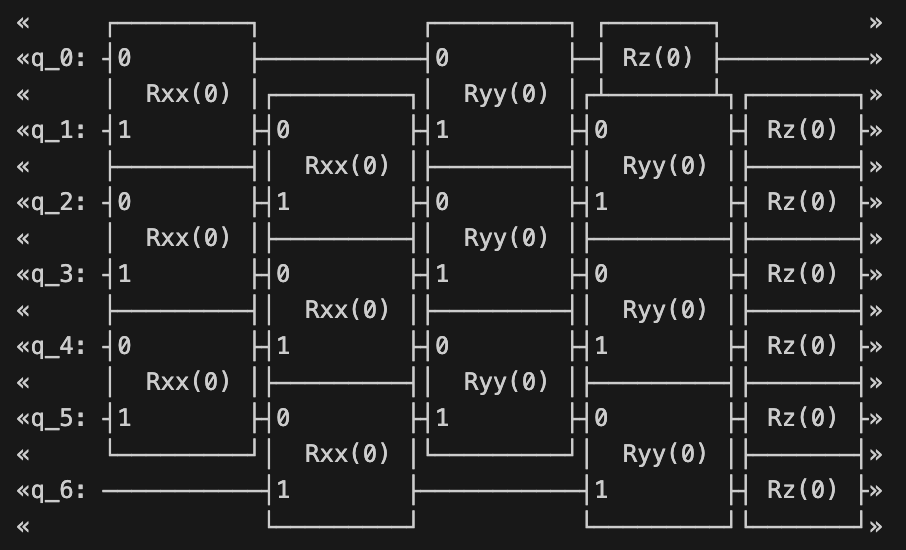.

We can calculate the trotter error of this decomposition using the same method from earlier, and we get this graph.

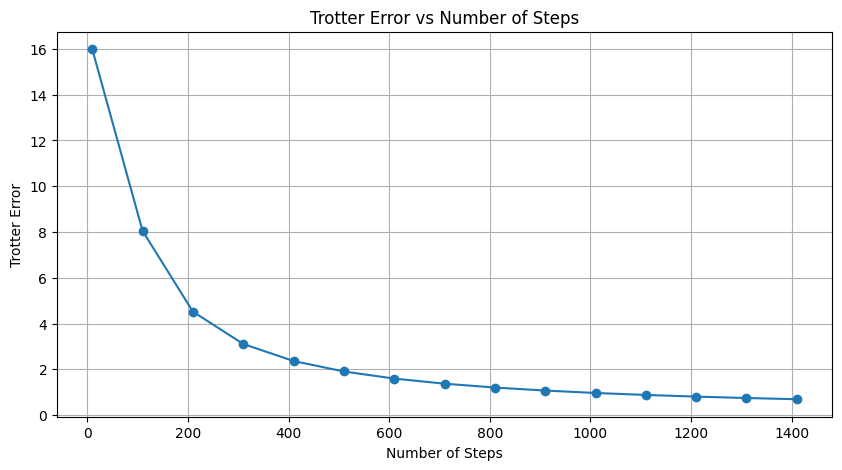

If we logscale the axes, we see that this graph exhibits a pretty good $1/n$ relation, which correlates with the findings from week 3 very well!

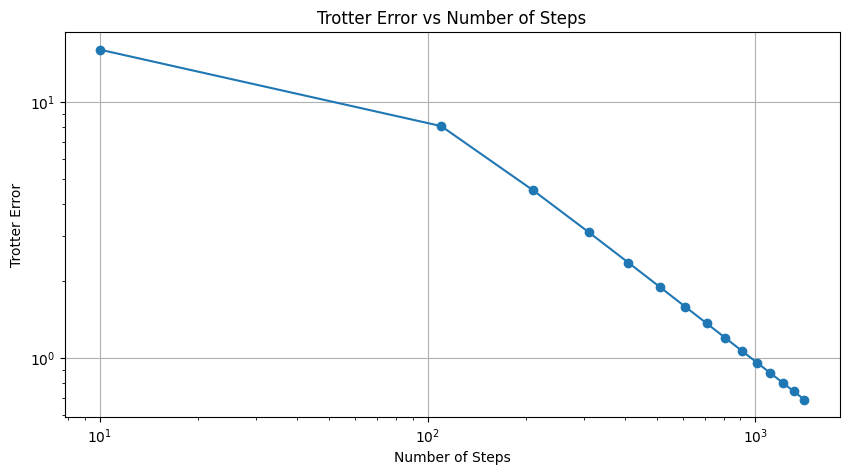